In [2]:
import numpy as np

import sys
sys.path.append('../')
import dense_nn
import sci_tools
import smc_samplers

import jax
import jax.numpy as jnp

import matplotlib.pylab as plt
%matplotlib inline

from time import time
from datetime import datetime

# Comparing SMC data annealers with minimization followed by MCMC

## Generate test data

In [3]:
random_polynomial = False

N = 200
ncolumns = 2
ndata = int(N / ncolumns)
INPUTS = np.random.normal(loc=0.0, scale=1, size=N).reshape(ndata, ncolumns)
LAYERSHAPE = (ncolumns,5,1)
if random_polynomial:
    rand_poly, (terms, coefficients) = sci_tools.gen_rand_poly(ncolumns, degree=3, nterms=3)
    TARGET = rand_poly(INPUTS).reshape((ndata,1))
    TARGET -= TARGET.mean()
    TARGET /= TARGET.std()
else:
    draw_param_scale = 0.5
    draw_error_scale = 0.5
    seed = datetime.now().microsecond
    params = dense_nn.init_nn_params(LAYERSHAPE, draw_param_scale, seed)
    key = jax.random.PRNGKey(seed + 1)
    error = jax.random.gamma(key, draw_error_scale, (1,))
    TRUE_TARGET = dense_nn.nn_predict(params, INPUTS, nonlinearity=dense_nn.positanh)
    key = jax.random.PRNGKey(seed + 1)
    TARGET = TRUE_TARGET + jax.random.normal(key, shape=TRUE_TARGET.shape)*error

In [4]:
len(INPUTS)

100

## Sequentially adding in the data
Data points are added one by one

  Resampled at stage 1 of 100
  Resampled at stage 3 of 100
  Resampled at stage 9 of 100
10% completed. ESS = 49.7, Progenitors=0.7
  Resampled at stage 12 of 100
  Resampled at stage 18 of 100
20% completed. ESS = 42.3, Progenitors=0.7
30% completed. ESS = 36.2, Progenitors=0.7
40% completed. ESS = 35.7, Progenitors=0.7
  Resampled at stage 43 of 100
50% completed. ESS = 49.0, Progenitors=0.6
60% completed. ESS = 44.4, Progenitors=0.4
70% completed. ESS = 45.0, Progenitors=0.4
80% completed. ESS = 40.7, Progenitors=0.4
  Resampled at stage 82 of 100
  Resampled at stage 85 of 100
90% completed. ESS = 47.8, Progenitors=0.7
  Resampled at stage 94 of 100
  Resampled at stage 95 of 100
  Resampled at stage 96 of 100
  Resampled at stage 99 of 100
100 % complete.
Time elapsed = 2.9655333201090497 mins.

Total number of steps =  60000


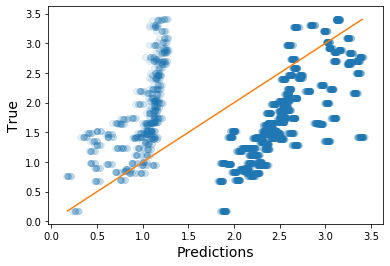

In [5]:
t0 = time()
nn, replica_unknowns, sample_sizes, resample_times = smc_samplers.smc_data_addition(INPUTS, TARGET, 50, 
                                                                       layer_shapes=LAYERSHAPE, draw_param_scale=0.5, 
                                                                       draw_error_scale=0.5, ess_frac=0.7, 
                                                                       nsteps=100, seed=0, loud=True)
print('Time elapsed =',(time()-t0)/60., 'mins.')

print('\nTotal number of steps = ',nn.nsteps)

for i in range(len(replica_unknowns)):
    nn.unknowns = replica_unknowns[i]
    plt.scatter(nn.predict(), nn.targets, alpha=0.1, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
plt.plot(x,x, color='C1')
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

## Geometrically annealing the data
Annealing the data in the same number of times as the data points to fairly compare against the above.

  Resampled at stage 1 of 100
10% completed. ESS = 34.1, Progenitors=0.4
  Resampled at stage 10 of 100
20% completed. ESS = 40.2, Progenitors=0.5
  Resampled at stage 24 of 100
30% completed. ESS = 47.0, Progenitors=0.7
40% completed. ESS = 36.9, Progenitors=0.5
  Resampled at stage 43 of 100
50% completed. ESS = 46.3, Progenitors=0.5
  Resampled at stage 59 of 100
60% completed. ESS = 49.8, Progenitors=0.5
70% completed. ESS = 32.6, Progenitors=0.4
  Resampled at stage 70 of 100
  Resampled at stage 77 of 100
80% completed. ESS = 45.1, Progenitors=0.5
  Resampled at stage 83 of 100
  Resampled at stage 89 of 100
90% completed. ESS = 49.3, Progenitors=0.5
  Resampled at stage 95 of 100
  Resampled at stage 99 of 100
100 % complete.
Time elapsed = 11.843019998073578 mins.

Total number of steps =  275000


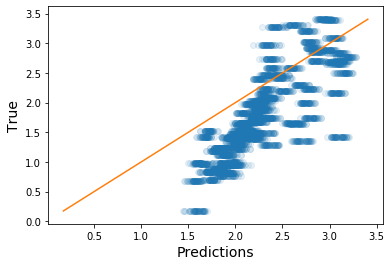

In [7]:
t0 = time()
nn, replica_unknowns, resample_times = smc_samplers.smc_geometric_likelihood(INPUTS, TARGET, nreplicas=50, layer_shapes=LAYERSHAPE,
                                                                nstages=ndata, draw_param_scale=0.5, draw_error_scale=0.5,
                                                                ess_frac=0.7, nsteps=100, seed=0, loud=True)
print('Time elapsed =',(time()-t0)/60., 'mins.')

print('\nTotal number of steps = ',nn.nsteps)

for i in range(len(replica_unknowns)):
    nn.unknowns = replica_unknowns[i]
    plt.scatter(nn.predict(), nn.targets, alpha=0.1, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
plt.plot(x,x, color='C1')
plt.xlabel('Predictions', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.show()

## Minimization followed by MCMC
How good is this strategy when it's run for a fewer steps than geometrical annealing?

In [11]:
nn = dense_nn.GaussianDenseNN(INPUTS, TARGET, layer_shapes=LAYERSHAPE, prior_weight_scale=0.5, prior_error_scale=0.5, seed=0)
nn.reinit_integrator(dt=0.0001, gamma=100, mass=10)

t0 = time()
# Minimize the energy.
nn.get_map(nsteps=3000)

energy = []
trace_sigma = []
predictions = []

nsteps = 50000
save_freq = 100
percent = 10
completion_freq = int(nsteps * percent / 100)

nn.seed += 1
key = jax.random.PRNGKey(nn.seed)
split_keys = jax.random.split(key, nsteps)
nn.seed += 1

print('\nStarting MCMC')
k=0.
for i in range(nsteps):
    nn.step(key=split_keys[i])
    if i % save_freq == 0:
        energy.append(nn.energy(nn.unknowns))
        trace_sigma.append(nn.unknowns[0])
        predictions.append(nn.predict())
        if nn.unknowns[0] < 0.:
            raise Exception('Sigma less than zero!')
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')

print('Time elapsed =',(time()-t0)/60., 'mins.')

figure, ax = plt.subplots(1,4, figsize=(15,5))
arr_energy = np.hstack(energy)
ax[0].plot(arr_energy)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Energy', fontsize=14)

arr_trace_sigma = np.hstack(trace_sigma)
ax[1].plot(arr_trace_sigma)
ax[1].axhline(error, ls='--', label='True sigma', color='grey', lw=3)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Sigma', fontsize=14)

for i in range(1, len(predictions), 100):
    ax[2].scatter(predictions[i], nn.targets, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[2].plot(x,x, color='C1')
ax[2].set_xlabel('Predictions', fontsize=14)
ax[2].set_ylabel('Response', fontsize=14)

for i in range(1, len(predictions),100):
    ax[3].scatter(predictions[i], TRUE_TARGET, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[3].plot(x,x, color='C1')
ax[3].set_xlabel('Predictions', fontsize=14)
ax[3].set_ylabel('True response', fontsize=14)

plt.tight_layout()
plt.show()

0.0% completed. Energy = 14726.74
10.0% completed. Energy = 983.39
20.0% completed. Energy = 112.64
30.0% completed. Energy = 23.73
40.0% completed. Energy = 19.35
50.0% completed. Energy = 18.30
60.0% completed. Energy = 17.33
70.0% completed. Energy = 16.33
80.0% completed. Energy = 15.26
90.0% completed. Energy = 14.11
100% completed. Energy = 14.11
0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.
Time elapsed = 2.345633248488108 mins.


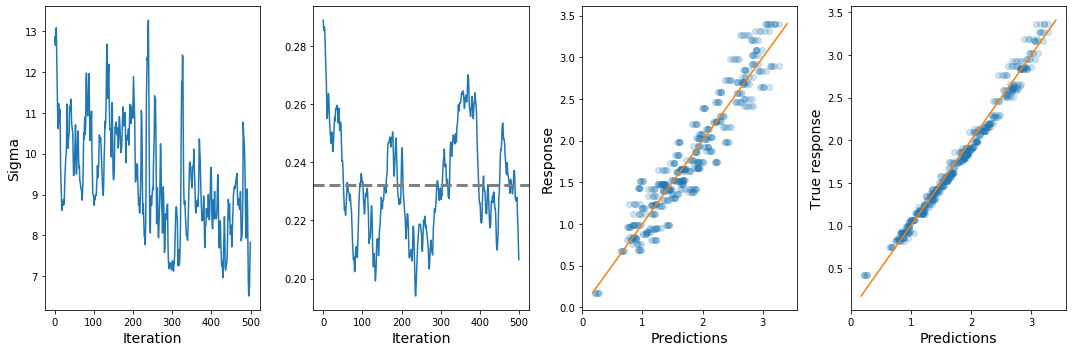

In [14]:
figure, ax = plt.subplots(1,4, figsize=(15,5))
arr_energy = np.hstack(energy)
ax[0].plot(arr_energy)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Energy', fontsize=14)

arr_trace_sigma = np.hstack(trace_sigma)
ax[1].plot(arr_trace_sigma)
ax[1].axhline(error, ls='--', label='True sigma', color='grey', lw=3)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Sigma', fontsize=14)

for i in range(1, len(predictions), 10):
    ax[2].scatter(predictions[i], nn.targets, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[2].plot(x,x, color='C1')
ax[2].set_xlabel('Predictions', fontsize=14)
ax[2].set_ylabel('Response', fontsize=14)

for i in range(1, len(predictions),10):
    ax[3].scatter(predictions[i], TRUE_TARGET, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[3].plot(x,x, color='C1')
ax[3].set_xlabel('Predictions', fontsize=14)
ax[3].set_ylabel('True response', fontsize=14)

plt.tight_layout()
plt.show()

#### Now cranking up the timestep by reducing the mass


Starting MCMC
0.0% completed.
10.0% completed.
20.0% completed.
30.0% completed.
40.0% completed.
50.0% completed.
60.0% completed.
70.0% completed.
80.0% completed.
90.0% completed.
100% completed.
Time elapsed = 2.217634383837382 mins.


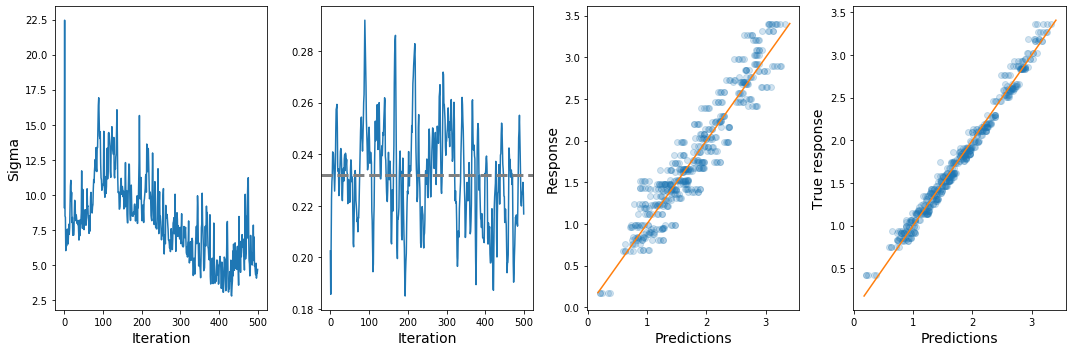

In [15]:
nn.reinit_integrator(dt=0.0001, gamma=100, mass=1)

t0 = time()

energy = []
trace_sigma = []
predictions = []

nsteps = 50000
save_freq = 100
percent = 10
completion_freq = int(nsteps * percent / 100)

nn.seed += 1
key = jax.random.PRNGKey(nn.seed)
split_keys = jax.random.split(key, nsteps)
nn.seed += 1

print('\nStarting MCMC')
k=0.
for i in range(nsteps):
    nn.step(key=split_keys[i])
    if i % save_freq == 0:
        energy.append(nn.energy(nn.unknowns))
        trace_sigma.append(nn.unknowns[0])
        predictions.append(nn.predict())
        if nn.unknowns[0] < 0.:
            raise Exception('Sigma less than zero!')
    if i % completion_freq == 0:
        print('{0}% completed.'.format(k*percent))
        k += 1
print('100% completed.')

print('Time elapsed =',(time()-t0)/60., 'mins.')

figure, ax = plt.subplots(1,4, figsize=(15,5))
arr_energy = np.hstack(energy)
ax[0].plot(arr_energy)
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Energy', fontsize=14)

arr_trace_sigma = np.hstack(trace_sigma)
ax[1].plot(arr_trace_sigma)
ax[1].axhline(error, ls='--', label='True sigma', color='grey', lw=3)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('Sigma', fontsize=14)

for i in range(1, len(predictions), 10):
    ax[2].scatter(predictions[i], nn.targets, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[2].plot(x,x, color='C1')
ax[2].set_xlabel('Predictions', fontsize=14)
ax[2].set_ylabel('Response', fontsize=14)

for i in range(1, len(predictions),10):
    ax[3].scatter(predictions[i], TRUE_TARGET, alpha=0.2, color='C0')
x = np.linspace(nn.targets.min(), nn.targets.max())
ax[3].plot(x,x, color='C1')
ax[3].set_xlabel('Predictions', fontsize=14)
ax[3].set_ylabel('True response', fontsize=14)

plt.tight_layout()
plt.show()

# H A P P Y

# S I M O N















# G G0[;='POOP